##### Zadanie Domowe

Poniżej podany jest zestaw danych. Zawiera on brakujące wartości. Twoim zadaniem jest przygotować ten zestaw danych do obróbki a następnie wytrenować klasyfikator przewidujący choroby serca dobierając ilość kroków oraz learning rate.

Wartością docelową jest `num`

Twoim celem jest odrzucenie zmiennych charakteryzujących się dużą ilością wartości brakujących oraz uzupełnienie pozostałych kolumn. Użyj do tego na przykład funkcji `pd.DataFrame.isna`, `pd.DataFrame.sum` oraz metody `pd.Series.fillna`.

Użyj metody `xgb.cv` do ustalenia przebiegu treningu. Postaraj się dobrać takie wartości ilości kroków oraz learning rate aby uniknąć przeuczenia (overfitu) w końcowym modelu. Zacznij od learning rate `0.01`. Kiedy klasyfikator zostanie przetrenowany, użyj wykresu błędu w zależności od ilości kroków aby wyznaczyć przybliżoną optymalną ilość drzew dla danego modelu i wytrenuj ostateczny model.

Dodatkowe info: `xgb` obsługuje brakujące wartości przez parametr `missing`. Możesz (nie musisz) użyć tego zamiast interpolacji brakujących wartości.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("heart.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         294 non-null    int64  
 1   sex         294 non-null    int64  
 2   cp          294 non-null    int64  
 3   trestbps    294 non-null    object 
 4   chol        294 non-null    object 
 5   fbs         294 non-null    object 
 6   restecg     294 non-null    object 
 7   thalach     294 non-null    object 
 8   exang       294 non-null    object 
 9   oldpeak     294 non-null    float64
 10  slope       294 non-null    object 
 11  ca          294 non-null    object 
 12  thal        294 non-null    object 
 13  num         294 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 32.3+ KB


### Sprawdzenie braków danych

In [2]:
# Wstępne info podaje, że w danych nie mam nulli, ale to zapewne spowodowane jest tym, 
# że większość kolumn jest typu object. Po obejrzeniu danych widać, że mamy tam dużo znaków zapytania.
# Poniżej kod którym sprawdzam ich dokładną ilość w każdej kolumnie.

feats = data.columns.to_list()

In [3]:
for i in feats:
    print(f"\n * * * * * *")
    print([i])
    vc_dict = data[i].value_counts().to_dict()
    try:
        print(f"ilość braków w kolumnie: {vc_dict['?']}")
    except KeyError:
        print("nie ma '?'")


 * * * * * *
['age']
nie ma '?'

 * * * * * *
['sex']
nie ma '?'

 * * * * * *
['cp']
nie ma '?'

 * * * * * *
['trestbps']
ilość braków w kolumnie: 1

 * * * * * *
['chol']
ilość braków w kolumnie: 23

 * * * * * *
['fbs']
ilość braków w kolumnie: 8

 * * * * * *
['restecg']
ilość braków w kolumnie: 1

 * * * * * *
['thalach']
ilość braków w kolumnie: 1

 * * * * * *
['exang']
ilość braków w kolumnie: 1

 * * * * * *
['oldpeak']
nie ma '?'

 * * * * * *
['slope']
ilość braków w kolumnie: 190

 * * * * * *
['ca']
ilość braków w kolumnie: 291

 * * * * * *
['thal']
ilość braków w kolumnie: 266

 * * * * * *
['num       ']
nie ma '?'


### Obsługa kolumn z brakami danych

In [4]:
# usuniecie ostatniej kolumny z białymi znakami i zastąpienie ją kolumną bez takich znaków
data['num'] = data['num       ']

In [5]:
# odrzucenie trzech kolumn (oraz kolumny z białymi zn.), w których braki danych są zbyt duże 
# i sięgają wartości od 64% w górę - kolumny 'slope', 'ca', 'thal'

data = data.drop(columns=['num       ', 'slope', 'ca', 'thal'], axis=1)

In [6]:
# zmiana '?' na NaN, aby można było te kolumny przekształcić w liczby zmienno-przecinkowe

data = data.replace(['?'], 'NaN')

In [7]:
feats2 = feats[3:9]
feats2

['trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang']

In [8]:
for i in range(0, len(feats2)):
    data[feats2[i]] = data[feats2[i]].astype('float64')

In [9]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,0
2,29,1,2,140.0,NaN,0.0,0.0,170.0,0.0,0.0,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
289,52,1,4,160.0,331.0,0.0,0.0,94.0,1.0,2.5,1
290,54,0,3,130.0,294.0,0.0,1.0,100.0,1.0,0.0,1
291,56,1,4,155.0,342.0,1.0,0.0,150.0,1.0,3.0,1
292,58,0,2,180.0,393.0,0.0,0.0,110.0,1.0,1.0,1


### Uzupełnianie braków

In [10]:
# Do kolumny 'trestbps' (1 brak wartości) zostanie dodana średnia, w tym przypadku policzona na zbiorze zdrowych pacjentów

health = data[data['num'] == 0]
sick = data[data['num'] == 1]
data['trestbps'] = data['trestbps'].fillna(round(health['trestbps'].mean()))

In [11]:
# Do kolumny 'thalach' (1 brak) zostanie dodana wartość średniej - tu także ze zbioru zdrowych pacjentów

data['thalach'] = data['thalach'].fillna(round(health['thalach'].mean()))

In [12]:
# Kolumna 'exang' (1 brak), wartość przyjmująca zero lub jeden, więc tu liczenie średniej nie ma sensu -
# - dodana zostanie mediana - w tym przypadku policzona na zbiorze zdrowych

exang_dict = (health['exang']).describe().to_dict()
data['exang'] = data['exang'].fillna(exang_dict['50%'])

In [13]:
# Ostatnia kolumna z mały brakiem - 'restecg'. W tym przypadku dotyczy pacjenta chorego. 
# Ze zbioru chorych dodana mediana (wartości zero lub jeden).

restecg_dict = (sick['restecg']).describe().to_dict()
data['restecg'] = data['restecg'].fillna(restecg_dict['50%'])

In [14]:
# Poniżej inputacja dla kolumny 'chol', w której brakowało 23 rekorków. W tym przypadku uzupełnione zostanie to średnią. 
# Dla zbioru zdrowych wartość 240, a dla chorych 269:

In [15]:
health['chol'].describe()

count    170.000000
mean     239.952941
std       56.694532
min       85.000000
25%      201.000000
50%      230.000000
75%      275.000000
max      468.000000
Name: chol, dtype: float64

In [16]:
sick['chol'].describe()

count    101.000000
mean     269.188119
std       79.911165
min      117.000000
25%      219.000000
50%      263.000000
75%      291.000000
max      603.000000
Name: chol, dtype: float64

In [17]:
for i in range(0, len(data)):
    if data['chol'].loc[i] == 'Nan' and data['num'] == 0:
        data['chol'] = data['chol'].fillna(240)
    else:
        data['chol'] = data['chol'].fillna(269)

In [18]:
# Poniżej inputacja dla ostatniej kolumny, w której są braki 'fbs'. W tej kolumnie czynnik przyjmuje wartość zero lub jeden.
# Sprawdzenie mediany dla zbioru zdrowych oraz chorych - w obu przypadkach wynosi ona zera i taka wartość będzie wstawiona.

In [19]:
health['fbs'].describe()

count    182.000000
mean       0.038462
std        0.192838
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: fbs, dtype: float64

In [20]:
sick['fbs'].describe()

count    104.00000
mean       0.12500
std        0.33232
min        0.00000
25%        0.00000
50%        0.00000
75%        0.00000
max        1.00000
Name: fbs, dtype: float64

In [21]:
data['fbs'] = data['fbs'].fillna(0)

In [22]:
# Po skończonym uzupełnianiu - kolumny, które były inputowane zostaną zamienione na typ 'int64', 
# ponieważ wszystkie posiadają liczby w całkowite. W całym zbiorze danych tylko 'oldpeak' posiada 'float64'.

In [23]:
for i in range(0, len(feats2)):
    data[feats2[i]] = data[feats2[i]].astype('int64')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  294 non-null    int64  
 4   chol      294 non-null    int64  
 5   fbs       294 non-null    int64  
 6   restecg   294 non-null    int64  
 7   thalach   294 non-null    int64  
 8   exang     294 non-null    int64  
 9   oldpeak   294 non-null    float64
 10  num       294 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 25.4 KB


### Zdefiniowanie zmiennej objaśnianej, import bibliotek

In [25]:
y = data['num']
X = data.drop(['num'], axis=1)

In [26]:
import xgboost as xgb
import matplotlib.pyplot as plt

In [27]:
data_dm = xgb.DMatrix(data=X.values, label=y.values)

In [28]:
params = {"objective":"reg:logistic", "max_depth":3, "learning_rate": 0.01, "reg_alpha": 1}

In [29]:
cv_results = xgb.cv(dtrain=data_dm, params=params, nfold=4, num_boost_round=100, 
                            metrics=["error", "auc"], as_pandas=True, seed=123) #nfold - liczba cv
cv_results

,train-error-mean,train-error-std,train-auc-mean,train-auc-std,test-error-mean,test-error-std,test-auc-mean,test-auc-std
0,0.149651,0.004196,0.887367,0.014802,0.210616,0.051894,0.816464,0.063904
1,0.147378,0.007223,0.887146,0.012974,0.210616,0.051894,0.821217,0.064697
2,0.147378,0.007223,0.887146,0.012974,0.210616,0.051894,0.821217,0.064697
3,0.147378,0.007223,0.889055,0.015537,0.210616,0.051894,0.834992,0.048347
4,0.147378,0.007223,0.889055,0.015537,0.210616,0.051894,0.834992,0.048347
...,...,...,...,...,...,...,...,...
95,0.146236,0.011438,0.934454,0.006887,0.210663,0.047657,0.860869,0.049349
96,0.146236,0.011438,0.934822,0.007167,0.210663,0.047657,0.860513,0.049608
97,0.146236,0.011438,0.934602,0.007242,0.210663,0.047657,0.860757,0.049098
98,0.146236,0.011438,0.935363,0.007492,0.210663,0.047657,0.862852,0.048694


Text(0, 0.5, 'Wartość funkcji błędu')

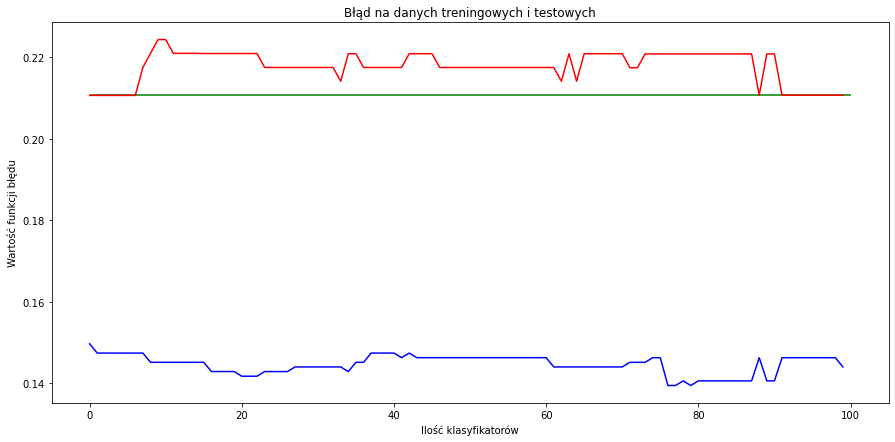

In [30]:
plt.figure(figsize=(15, 7))
plt.title("Błąd na danych treningowych i testowych")
plt.plot(cv_results["train-error-mean"], color="b")
plt.plot(cv_results["test-error-mean"], color="r")
plt.hlines([cv_results["test-error-mean"].min()], xmin=0, xmax=100, color="g")
plt.xlabel("Ilość klasyfikatorów")
plt.ylabel("Wartość funkcji błędu")

Text(0, 0.5, 'Wartość auc')

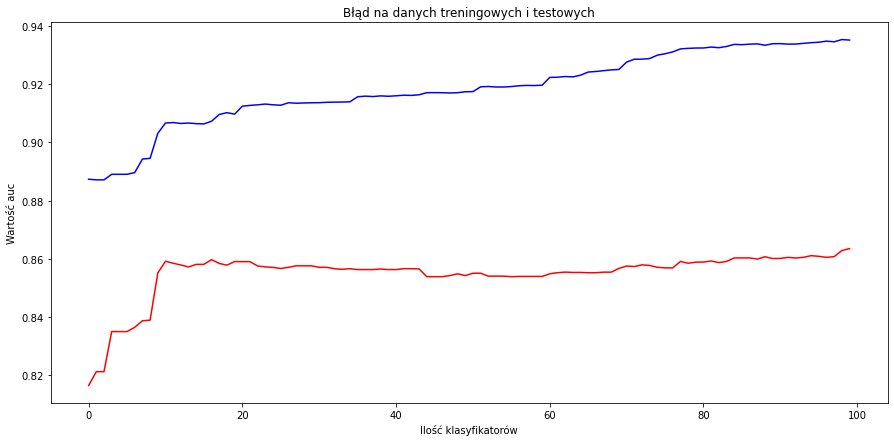

In [31]:
plt.figure(figsize=(15, 7))
plt.title("Błąd na danych treningowych i testowych")
plt.plot(cv_results["train-auc-mean"], color="b")
plt.plot(cv_results["test-auc-mean"], color="r")
plt.xlabel("Ilość klasyfikatorów")
plt.ylabel("Wartość auc")

Powyżej widzimy, że dla parametru `learning_rate = 0.01` crossvalidation daje na zbiorze testowym dość przeciętny wynik błędu - w tym przypadku minimalny przyjmuje wartość około `0.21` (minimalny błąd został na pierwszym wykresie zaznaczony zieloną linią). Dlatego też poniżej przeprowadzono analizę jak wpływa dobór parametru `learning rate` na wyniki modelu.

In [32]:
lr_array = [0.5, 0.3, 0.1, 0.05, 0.03, 0.01, 0.003, 0.001]

{'objective': 'reg:logistic', 'max_depth': 3, 'learning_rate': 0.5, 'reg_alpha': 1}
{'objective': 'reg:logistic', 'max_depth': 3, 'learning_rate': 0.3, 'reg_alpha': 1}
{'objective': 'reg:logistic', 'max_depth': 3, 'learning_rate': 0.1, 'reg_alpha': 1}
{'objective': 'reg:logistic', 'max_depth': 3, 'learning_rate': 0.05, 'reg_alpha': 1}
{'objective': 'reg:logistic', 'max_depth': 3, 'learning_rate': 0.03, 'reg_alpha': 1}
{'objective': 'reg:logistic', 'max_depth': 3, 'learning_rate': 0.01, 'reg_alpha': 1}
{'objective': 'reg:logistic', 'max_depth': 3, 'learning_rate': 0.003, 'reg_alpha': 1}
{'objective': 'reg:logistic', 'max_depth': 3, 'learning_rate': 0.001, 'reg_alpha': 1}


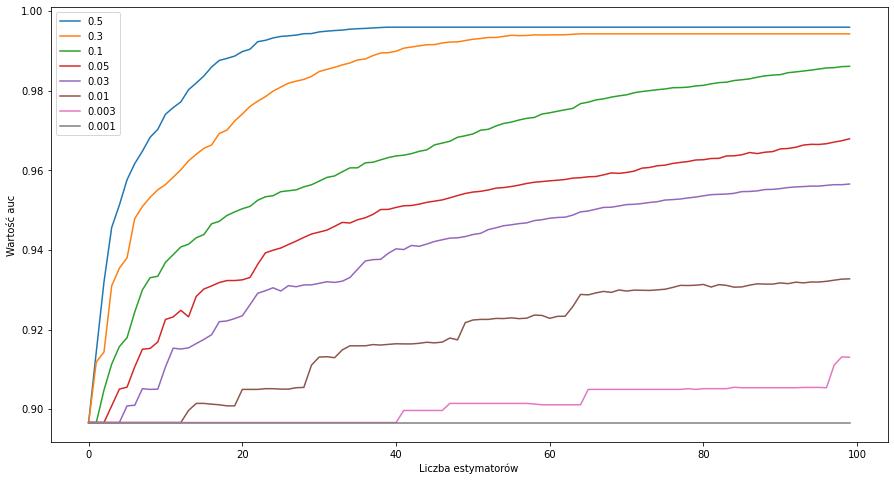

In [33]:
plt.figure(figsize=(15,8))

for lr in lr_array:
    params['learning_rate'] = lr
    print(params)
    cv_results = xgb.cv(
        dtrain=data_dm,
        params=params, 
        num_boost_round=100,
        metrics='auc',
        as_pandas=True,
        seed=123
    )
    plt.plot(cv_results['train-auc-mean'])

plt.xlabel('Liczba estymatorów')
plt.ylabel('Wartość auc')
plt.legend(lr_array)
plt.show()

In [34]:
for learning_rate in lr_array:
    params['learning_rate'] = learning_rate
#     my_params.update(params)
    cv_results = xgb.cv(
        dtrain=data_dm, 
        params=params, 
        nfold=3, 
        num_boost_round=150, metrics=["error"], as_pandas=True)
    best_rounds = cv_results["test-error-mean"].argmin()
    score = cv_results["test-error-mean"].min()
    print("Dla learning_rate {} najlepszy wynik to {} po {} iteracjach".format(
        learning_rate, score, best_rounds
    ))

Dla learning_rate 0.5 najlepszy wynik to 0.18707466666666664 po 3 iteracjach
Dla learning_rate 0.3 najlepszy wynik to 0.19387766666666664 po 5 iteracjach
Dla learning_rate 0.1 najlepszy wynik to 0.18367333333333333 po 10 iteracjach
Dla learning_rate 0.05 najlepszy wynik to 0.19047633333333333 po 21 iteracjach
Dla learning_rate 0.03 najlepszy wynik to 0.187075 po 37 iteracjach
Dla learning_rate 0.01 najlepszy wynik to 0.187075 po 117 iteracjach
Dla learning_rate 0.003 najlepszy wynik to 0.20068033333333335 po 63 iteracjach
Dla learning_rate 0.001 najlepszy wynik to 0.2040816666666667 po 74 iteracjach


Z powyższych wynika, że najbardziej optymalna wartość dla parametru `learning_rate to 0.1`. Wartości od 0.3 do góry mają dobre wyniki już po kilku iteracjach, ale zapewne prowadzi to do przeuczenia modelu.

In [35]:
params = {"objective":"reg:logistic", "max_depth":3, "learning_rate": 0.1, "reg_alpha": 1}

In [36]:
cv_results = xgb.cv(dtrain=data_dm, params=params, nfold=4, num_boost_round=100, 
                            metrics=["auc"], as_pandas=True, seed=123)

Text(0, 0.5, 'Wartość auc')

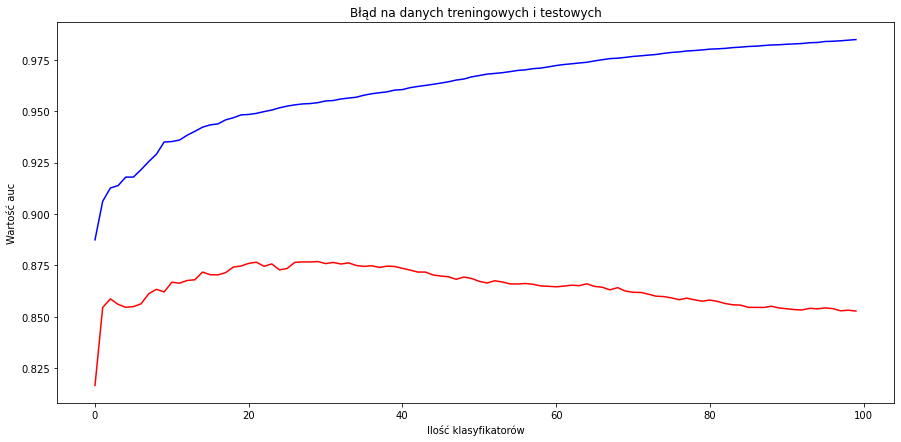

In [37]:
plt.figure(figsize=(15, 7))
plt.title("Błąd na danych treningowych i testowych")
plt.plot(cv_results["train-auc-mean"], color="b")
plt.plot(cv_results["test-auc-mean"], color="r")
plt.xlabel("Ilość klasyfikatorów")
plt.ylabel("Wartość auc")

Powyżej wykrec dla `learning_rate` na poziomie `0.1`. Widać, że dla takiej wartości parametru - najbardziej optymalna `liczba klasyfikatorów` to 20. Powyżej tej wartości, AUC już zaczyna spadać.

### Inplementacja ostatecznego modelu

In [69]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

In [82]:
# podział na zbiór testowy i treningowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [94]:
# poszukiwanie pozostalych optymalnych parametrow za pomocą GridSearchCV

params = {
        'max_depth': [3, 4, 5], 
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'reg_alpha': [0, 0.3, 0.6, 1], 
        'reg_lambda': [0, 0.3, 0.6, 1]
        }

In [95]:
xgb_model = xgb.XGBClassifier(learning_rate=0.1, objective='reg:logistic', n_estimators=20)

In [96]:
import warnings
warnings.filterwarnings("ignore")

In [97]:
grid = GridSearchCV(estimator=xgb_model, param_grid=params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_esti...
                                     objective='reg:logistic', predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                

In [98]:
grid.best_params_

{'colsample_bytree': 0.6,
 'gamma': 1,
 'max_depth': 4,
 'min_child_weight': 1,
 'reg_alpha': 1,
 'reg_lambda': 0.3,
 'subsample': 0.6}

In [99]:
grid.best_score_

0.8341463414634147

In [100]:
xgb_best = xgb.XGBClassifier(**grid.best_params_, learning_rate=0.1, objective='reg:logistic', n_estimators=20, random_state=40)
xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', predictor='auto', random_state=40,
              reg_alpha=1, reg_lambda=0.3, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [101]:
y_pred = xgb_best.predict(X_test)

In [102]:
print("Raport klasyfikacyjny: \n", classification_report(y_test, y_pred))

Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           0       0.92      0.83      0.88        59
           1       0.72      0.87      0.79        30

    accuracy                           0.84        89
   macro avg       0.82      0.85      0.83        89
weighted avg       0.86      0.84      0.85        89



### Podsumowanie
Na pierwszy rzut oka, powyższy raport klasyfikacyjny z ostatecznego modelu ma dość dobre wyniki, jednak jeśli uwzględnimy czego dotyczą dane, to raczej będą one niewystarczające, aby powyższy model wdrożyć na produkcję. Dane o pacjentach, którzy chorują lub nie chorują na choroby układu krążenia, to dość delikatny temat i tu raczej margines pomyłki powinien być jak najmniejszy. Wpływ na niedoskonałość modelu, ma z pewnością zbyt mała liczba rekordów (cały dataset zawiera niecałe 300 wersów), więc być może sukcesywne jego zwiększania i aktualizowanie, mogłoby się przyczynić do osiągania lepszych wyników i ponownego rozważenia wdrożenia go na produkcję.